# 5. Optimization methods
Optimization methods attempt to find the minimum or maximum of functions. Here the steepest descent, conjugate gradient, Newton-Raphson, and Broyden-Fletcher-Goldfarb-Shanno methods are presented.

Functions with two variables can be visualized as a surface (i.e., a contour map) where the lowest and highest point on the map corresponds to the function’s max and min.  Although higher dimensional functions cannot be readily visualized, the analogy of traversing a surface is still convenient. Using the map concept, one can appreciate the general features of these algorithms. 

1.	Select an initial guess, which is a point on the surface
2.	Determine a direction to move
3.	Take a step by moving along the determined direction
4.	Test for convergence (Is the difference between the function’s values for the last two points less than a threshold value?)
5.	Repeat steps 2 to 4 to continue searching surface


The most significant difference in the algorithms presented in this notebook is how each defines the step direction. The various approaches are described in the following sections.  It is important to emphasize that numerical optimizations can be extremely time consuming.  For the optimization to complete in a reasonable amount of time, the threshold for the convergence criteria must be selected with care.  In addition, an optimization algorithm should always limit the number of iterations so as not to get stuck in an endless search.  Lastly, the method should keep track of the step size because an indication that the search is proceeding successfully is a decrease in successive step sizes.

# 5.1 Steepest Descent

The steepest descent method is the simplest iterative method of optimization method. Steepest descent makes iterative steps in the direction of greatest decrease. A function’s gradient at a point determines the direction where the rate of changes is the highest.  Thus the opposite direction will be the steepest decent.

For an initial guess, $x_0$, the search direction, $sd_0$, that is in the direction of steepest descent becomes

 $$ sd_0 = -\nabla f(x_0)$$

A step is taken by using a line search minimization along this search direction, 

$$ x_i = x_0 + \lambda sd_0 $$

where $\lambda$ minimizes $f(x)$ in the search direction. For simplicity, the details of the of the minimization are ignored.

A new search direction is constructed as the direction of steepest descent at the new point.

 $$ sd_i = -\nabla f(x_i)$$
 
 
As an example, the cell directly below implements steepest descent on the function,
 $$ f(x,y) = sin(0.5x^2-0.25y^2+3)*cos(2x+1-e^y)$$
Following the code is an image depicting steepest descent implemented on the surface of this function.


In [18]:
###########
# IMPORTS #
###########
import numpy as np
from scipy.optimize import line_search as linesearch
import scipy.linalg as spla
import scipy as sp
import plotting_functions as pf
import matplotlib.pyplot as plt
%matplotlib notebook
#############
# FUNCTIONS #
#############


def f(point):
    x = point[0]
    y = point[1]
    return np.sin(0.5 * x**2 - 0.25 * y**2 + 3) * np.cos(2 * x + 1 - np.exp(y))


def partial_f_partial_x(x, y):
    part1 = x * np.cos(0.5 * x**2 - 0.25 * y**2 + 3) * \
        np.cos(2 * x + 1 - np.exp(y))
    part2 = -2 * np.sin(0.5 * x**2 - 0.25 * y**2 + 3) * \
        np.sin(2 * x + 1 - np.exp(y))
    return part1 + part2


def partial_f_partial_y(x, y):
    part1 = np.exp(y) * np.sin(0.5 * x**2 - 0.25 * y**2 + 3) * \
        np.sin(2 * x + 1 - np.exp(y))
    part2 = -0.5 * y * \
        np.cos(0.5 * x**2 - 0.25 * y**2 + 3) * np.cos(2 * x + 1 - np.exp(y))
    return part1 + part2


def Gradient(point):
    x = point[0]
    y = point[1]
    return np.array([partial_f_partial_x(x, y), partial_f_partial_y(x, y)])


def partial_sq_f_partial_x_sq(x, y):
    part1 = -4 * x * \
        np.cos(0.5 * x**2 - 0.25 * y**2 + 3) * np.sin(2 * x + 1 - np.exp(y))
    part2 = -4 * np.sin(0.5 * x**2 - 0.25 * y**2 + 3) * \
        np.cos(2 * x + 1 - np.exp(y))
    part3 = np.cos(2 * x + 1 - np.exp(y)) * (np.cos(0.5 * x**2 -
                                                    0.25 * y**2 + 3) - (x**2) * np.sin(0.5 * x**2 - 0.25 * y**2 + 3))
    return part1 + part2 + part3


def partial_sq_f_partial_y_sq(x, y):
    part1 = -np.exp(y) * y * np.cos(0.5 * x**2 - 0.25 * y **
                                    2 + 3) * np.sin(2 * x + 1 - np.exp(y))
    part2 = np.sin(0.5 * x**2 - 0.25 * y**2 + 3) * ((np.exp(y) * np.sin(2 *
                                                                        x + 1 - np.exp(y))) - (np.exp(2 * y) * np.cos(2 * x + 1 - np.exp(y))))
    part3 = np.cos(2 * x + 1 - np.exp(y)) * ((-0.25 * y**2 * np.sin(0.5 *
                                                                    x**2 - 0.25 * y**2 + 3)) - (0.5 * np.cos(0.5 * x**2 - 0.25 * y**2 + 3)))
    return part1 + part2 + part3


def partial_sq_f_partial_x_y(x, y):
    part1 = (x * np.exp(y)) * np.cos(0.5 * x**2 - 0.25 * y**2 + 3) * \
        np.sin(2 * x + 1 - np.exp(y))
    part2 = y * np.cos(0.5 * x**2 - 0.25 * y**2 + 3) * \
        np.sin(2 * x + 1 - np.exp(y))
    part3 = (2 * np.exp(y)) * np.sin(0.5 * x**2 - 0.25 * y**2 + 3) * \
        np.cos(2 * x + 1 - np.exp(y))
    part4 = (0.5 * x * y) * np.sin(0.5 * x**2 - 0.25 * y**2 + 3) * \
        np.cos(2 * x + 1 - np.exp(y))
    return part1 + part2 + part3 + part4


def Hessian(point):
    x = point[0]
    y = point[1]
    part1 = partial_sq_f_partial_x_sq(x, y)
    part2 = partial_sq_f_partial_x_y(x, y)
    part3 = partial_sq_f_partial_y_sq(x, y)
    return np.array([[part1, part2], [part2, part3]])
# If you don't have analytical gradients... Use numerical gradients! 
# def Central_Diff_X(a,y,h):
#     return (f((a+h,y)) - f((a-h,y))) / (2*h)
# def Central_Diff_Y(x,b,h):
#     return (f((x,b+h)) - f((x,b-h))) / (2*h)
# def Gradient(point):
#     x= point[0]
#     y = point[1]
#     step = 1e-6
#     return np.array([Central_Diff_X(x,y,step),Central_Diff_Y(x,y,step)])
# def Central_Diff_2nd_X(a,y,h):
# Approximation by Central Difference Method
#         return (f((a+h,y)) - 2*f((a,y)) + f((a-h,y))) / (h**2)
# def Central_Diff_2nd_Y(x,b,h):
# Approximation by Central Difference Method
#         return (f((x,b+h)) - 2*f((x,b)) + f((x,b-h))) / (h**2)
# def Central_Diff_2nd_XY(a,b,h):
# Approximation by Central Difference Method
#         return (-1.0/(2*h**2))*(f((a+h,b))+f((a-h,b))+f((a,b+h))+f((a,b-h))-(2*f((a,b)))-f((a+h,b+h))-f((a-h,b-h)))
# def Hessian(a,b):
#     step = 1e-6
#     return np.array([[Central_Diff_2nd_X(a,b,step),Central_Diff_2nd_XY(a,b,step)],[Central_Diff_2nd_XY(a,b,step),Central_Diff_2nd_Y(a,b,step)]])
##########
# GLOBAL VARS
##########
# initial guess
initial_guess = np.array((1.6, -1.5))  
# convergence criteria
residual_tolerance = 1e-6  
update_tolerance = 1e-5
IT_MAX = 1000
# domain for plotting
xminimum = -1
xmaximum = 2
yminimum = -4
ymaximum = 1
#data structures to summarize resules
steps_per_method = dict()
difference_per_method = dict()


In [17]:
##########
#MAIN CODE
##########
old_guess = initial_guess
search_direction = -Gradient(old_guess) # set the search direction to the negative gradient at the initial guess
converged = False 
num_steps = 0
steps_x =[]
steps_y =[]
steps_x.append(old_guess[0])
steps_y.append(old_guess[1])
#repeat until convergenced or exceed IT_MAX
while not converged and num_steps <= IT_MAX: 
    print("STEP {:d}".format(num_steps))
    num_steps+=1
    gamma = linesearch(f,Gradient,old_guess,search_direction)[0] # find the step size that minimizes f along the search direction
    if gamma == None: 
        print("ERROR: No appropriate step size found. Exiting minimization")
        exit()
    else:
        new_guess = old_guess + gamma*search_direction # update the current guess
        search_direction = -Gradient(new_guess) # set the new search direction to the negative gradient at the new guess
        diff = old_guess-new_guess # calculate the vector difference of the old guess and new guess
        diff = np.sqrt(np.dot(diff,diff)) # calculate the magnitude of the separation between the old guess and the new guess
        print("OLD GUESS: {}".format(old_guess))
        print("NEW GUESS: {}".format(new_guess))
        print("DIFFERENCE: {}".format(diff))
        old_guess = new_guess # update the old guess so we can take another step
        steps_x.append(old_guess[0])
        steps_y.append(old_guess[1])
        if(diff<residual_tolerance): # if the step was small enough consider this the minimum
            converged=True
steps_x = np.array(steps_x)
steps_y = np.array(steps_y)
steps_per_method["Steepest Descent"] = num_steps
difference_per_method["Steepest Descent"] = diff


STEP 0
OLD GUESS: [ 1.6 -1.5]
NEW GUESS: [ 1.32197638 -3.03485489]
DIFFERENCE: 1.5598322571776573
STEP 1
OLD GUESS: [ 1.32197638 -3.03485489]
NEW GUESS: [ 1.09237061 -3.02949091]
DIFFERENCE: 0.2296684169793337
STEP 2
OLD GUESS: [ 1.09237061 -3.02949091]
NEW GUESS: [ 1.16003733 -2.93884683]
DIFFERENCE: 0.11311557988600016
STEP 3
OLD GUESS: [ 1.16003733 -2.93884683]
NEW GUESS: [ 1.10514384 -2.91206942]
DIFFERENCE: 0.06107638859209346
STEP 4
OLD GUESS: [ 1.10514384 -2.91206942]
NEW GUESS: [ 1.12040319 -2.88218061]
DIFFERENCE: 0.03355874189052971
STEP 5
OLD GUESS: [ 1.12040319 -2.88218061]
NEW GUESS: [ 1.10175656 -2.87314903]
DIFFERENCE: 0.020718741336484377
STEP 6
OLD GUESS: [ 1.10175656 -2.87314903]
NEW GUESS: [ 1.10688367 -2.86270543]
DIFFERENCE: 0.011634255693789298
STEP 7
OLD GUESS: [ 1.10688367 -2.86270543]
NEW GUESS: [ 1.10040725 -2.8595727 ]
DIFFERENCE: 0.007194303591980734
STEP 8
OLD GUESS: [ 1.10040725 -2.8595727 ]
NEW GUESS: [ 1.10218593 -2.85591147]
DIFFERENCE: 0.00407041844596

<IPython.core.display.Javascript object>


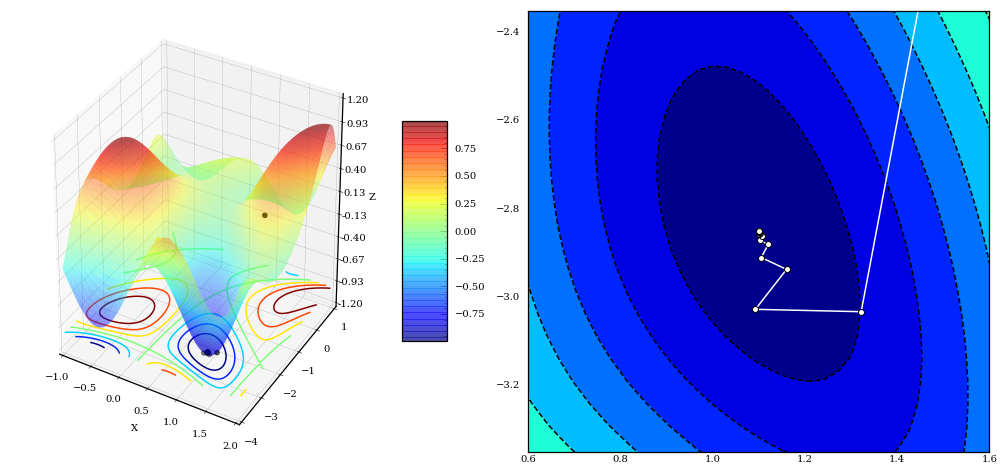

In [19]:
pf.plot_func(xminimum, xmaximum, yminimum, ymaximum, steps_x, steps_y, f)

# 5.2 Conjugate Gradient #

Conjugate gradient is very similar to the  steepest descent method, however the method attempts to ensure previous progress is not undone with future search steps. The added restriction is called conjugacy.Again, for an initial guess, $x_0$ the starting search direction, $sd_0$ is taken as the negative gradient.

 $$ sd_0 = -\nabla f(x_0)$$

The line search minimization along this search direction provides the step size. All new search directions are constructed by including a term to prevent successive steps from diminishing progress made from the previous search direction.   This second term is determined through a process similar to orthogonalization.

$$ sd_{i+1} = -\nabla f(x_{i+1}) + \frac{(-\nabla f(x_{i+1})) \bullet (-\nabla f(x_{i+1})) }{(-\nabla f(x_{i})) \bullet (-\nabla f(x_{i}))} sd_{i} $$

In practice, the line search minimization may fail because the search direction may point uphill.
This can be resolved by resetting the search direction to point in the direction of steepest descent.

The code below applies the conjugate gradient method to the example function and plots the search path.

In [20]:
#############
# MAIN CODE #
#############
converged = False
num_steps = 0
old_guess = initial_guess
old_grad = -Gradient(old_guess)
# set first search direction in the direction of steepest descent
old_search_direction = old_grad
steps_x = []
steps_y = []
steps_x.append(old_guess[0])
steps_y.append(old_guess[1])
while not converged and num_steps <= IT_MAX:
    print("STEP {:d}".format(num_steps))
    alpha = linesearch(f, Gradient, old_guess, old_search_direction)[0]
    if alpha == None:
        print("WARNING: LINE SEARCH DID NOT CONVERGE... RESETTING SEARCH DIRECTION TO STEEPEST DESCENT!")
        old_search_direction = -Gradient(old_guess)
        alpha = linesearch(f, Gradient, old_guess, old_search_direction)[0]  # step size
    new_guess = old_guess + alpha * old_search_direction
    new_grad = -Gradient(new_guess)
    # gamma encompasses the fraction in the above equation
    gamma = np.dot(new_grad - old_grad, new_grad) / np.dot(old_grad, old_grad)
    # update the search direction
    new_search_direction = new_grad + np.dot(gamma, old_search_direction)
    diff = old_guess - new_guess
    diff = np.sqrt(np.dot(diff, diff))
    print("OLD GUESS: {}".format(old_guess))
    print("NEW GUESS: {}".format(new_guess))
    print("DIFFERENCE: {}".format(diff))
    num_steps += 1
    old_guess = new_guess
    old_grad = new_grad
    old_search_direction = new_search_direction
    steps_x.append(old_guess[0])
    steps_y.append(old_guess[1])
    if(diff < residual_tolerance):
        converged = True
steps_x = np.array(steps_x)
steps_y = np.array(steps_y)
steps_per_method["Conjugate Gradient"] = num_steps
difference_per_method["Conjugate Gradient"] = diff


STEP 0
OLD GUESS: [ 1.6 -1.5]
NEW GUESS: [ 1.32197638 -3.03485489]
DIFFERENCE: 1.5598322571776573
STEP 1
OLD GUESS: [ 1.32197638 -3.03485489]
NEW GUESS: [ 1.25117431 -3.11742844]
DIFFERENCE: 0.10877188836897828
STEP 2
OLD GUESS: [ 1.25117431 -3.11742844]
NEW GUESS: [ 1.01718709 -2.64762478]
DIFFERENCE: 0.5248480651245814
STEP 3
OLD GUESS: [ 1.01718709 -2.64762478]
NEW GUESS: [ 1.17167864 -2.91118464]
DIFFERENCE: 0.30550194148936843
STEP 4
OLD GUESS: [ 1.17167864 -2.91118464]
NEW GUESS: [ 1.16876664 -2.92601998]
DIFFERENCE: 0.015118437799572153
STEP 5
OLD GUESS: [ 1.16876664 -2.92601998]
NEW GUESS: [ 1.10661245 -2.90490495]
DIFFERENCE: 0.06564287599679641
STEP 6
OLD GUESS: [ 1.10661245 -2.90490495]
NEW GUESS: [ 1.09634861 -2.85069584]
DIFFERENCE: 0.055172229948081374
STEP 7
OLD GUESS: [ 1.09634861 -2.85069584]
NEW GUESS: [ 1.09951107 -2.85152136]
DIFFERENCE: 0.003268432794029037
STEP 8
OLD GUESS: [ 1.09951107 -2.85152136]
NEW GUESS: [ 1.09965655 -2.85224376]
DIFFERENCE: 0.00073690731754

/home/shiv/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


<IPython.core.display.Javascript object>


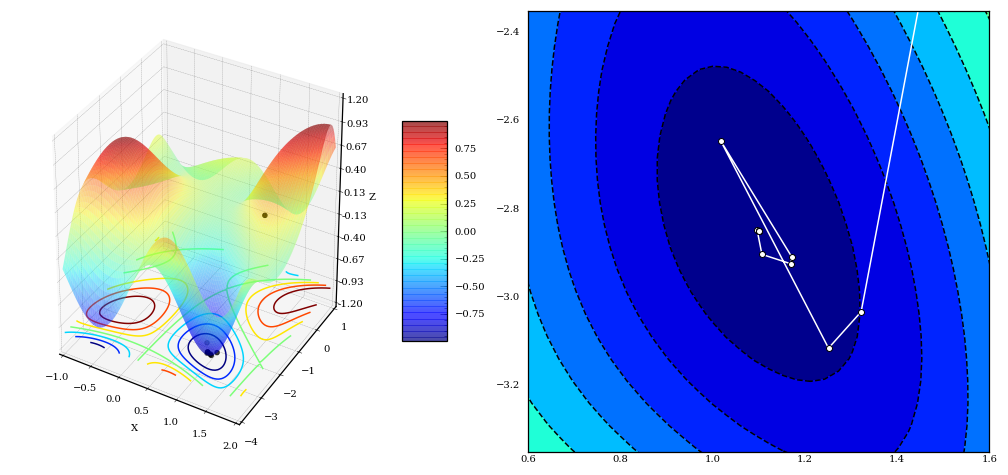

In [21]:
pf.plot_func(xminimum, xmaximum, yminimum, ymaximum, steps_x, steps_y, f)

# 5.3 Newton-Raphson

In the root-finding section of these lessons, the Newton-Raphson root finding method was described for a one-dimensional system. This method can be extended to higher dimensions. As a reminder, the Newton-Raphson method takes iterative steps:

$$x_{i+1}\ =\ x_i - \frac{f(x_i)}{f'(x_i)}$$

To minimize the first derivative to find an extremum, the following iterative equation could be used:
$$x_{i+1}\ =\ x_i - \frac{f'(x_i)}{f''(x_i)}$$

To optimize a higher order function, the Hessian matrix is introduced.
The Hessian is a square matrix composed of second derivatives that describe the local curvature of a function. The iterative steps are given by:
$$ p_i = (x_i,y_i) $$
and
$$p_{i+1} = p_i - \gamma[H(p_i)]^{-1}]\nabla f(p_i)$$

where the step size, $\gamma$, is found using a line search and $H(p_i)$ is the Hessian:
$$H(p_i)= \ \begin{bmatrix}
{\frac{\partial^2 f(x_i,y_i)}{\partial x^2}} 
& {\frac{\partial^2 f(x_i,y_i)}{\partial x \partial y}} \\
{\frac{\partial^2 f(x_i,y_i)}{\partial y \partial x}} 
& {\frac{\partial^2 f(x_i,y_i)}{\partial y^2}} 
\end{bmatrix} $$


It is important to note that the Newton-Raphson method requires the Hessian to be positive definite, which ensures a local minimum near $p_i$ is isolated and not a saddle point or local maximum. We will see below that the Newton-Raphson method finds the minimum of a well-behaved, convex function, such as $x^2\ +\ y^2$. If we solve for the Hessian of this function:
$$Hf(x,y)= \ \begin{bmatrix}
{\frac{\partial^2 f(x,y)}{\partial x^2}} 
& {\frac{\partial^2 f(x,y)}{\partial x \partial y}} \\
{\frac{\partial^2 f(x,y)}{\partial y \partial x}} 
& {\frac{\partial^2 f(x,y)}{\partial y^2}} 
\end{bmatrix} $$
$$Hf(x,y)= \ \begin{bmatrix}
{\frac{\partial^2 (x^2+y^2)}{\partial x^2}} 
& {\frac{\partial^2 (x^2+y^2)}{\partial x \partial y}} \\
{\frac{\partial^2 (x^2+y^2)}{\partial y \partial x}} 
& {\frac{\partial^2 (x^2+y^2)}{\partial y^2}} 
\end{bmatrix} $$

$$Hf(x,y)= \ \begin{bmatrix}
2
& 0 \\
0 
& 2 
\end{bmatrix} $$
These positive values of the Hessian indicate that our function has a local minimum, thus Newton's method of optimization will perform well.
Despite the requirement of a positive definite Hessian, the Newton-Raphson's method has excellent convergence since most functions near a minimum resemble $x^2\ +\ y^2$.

The code below applies the Newton-Raphson optimization method to the example function and plots the optimization path.

In [22]:
##########
# MAIN CODE
##########
old_guess = initial_guess
old_search_direction = -Gradient(old_guess)
num_steps = 0
converged = False
steps_x = []
steps_y = []
steps_x.append(old_guess[0])
steps_y.append(old_guess[1])
while not converged and num_steps <= IT_MAX:
    print("STEP {:d}".format(num_steps))
    num_steps += 1
    A = Hessian(old_guess)
    try:
        if num_steps == 1:
            new_search_direction = -Gradient(old_guess)
            gamma = linesearch(
                f, Gradient, old_guess, new_search_direction)[0]  # step size
            new_guess = old_guess + gamma * new_search_direction
        else:
            new_search_direction = spla.solve(A, -Gradient(old_guess))
            new_guess = old_guess + new_search_direction
    except:
        print("WARNING: HESSIAN IS NOT POSITIVE DEFINITE... RESETTING SEARCH DIRECTION TO STEEPEST DESCENT!")
        new_search_direction = -Gradient(old_guess)
        gamma = linesearch(f, Gradient, old_guess, new_search_direction)[
            0]  # step size
        new_guess = old_guess + gamma * new_search_direction
    diff = old_guess - new_guess
    diff = np.sqrt(np.dot(diff, diff))
    print("OLD GUESS: {}".format(old_guess))
    print("NEW GUESS: {}".format(new_guess))
    print("DIFFERENCE: {}".format(diff))
    old_guess = new_guess
    steps_x.append(old_guess[0])
    steps_y.append(old_guess[1])
    old_search_direction = new_search_direction
    if(diff < residual_tolerance):
        converged = True
steps_x = np.array(steps_x)
steps_y = np.array(steps_y)
steps_per_method["Newton-Raphson"] = num_steps
difference_per_method["Newton-Raphson"] = diff


STEP 0
OLD GUESS: [ 1.6 -1.5]
NEW GUESS: [ 1.32197638 -3.03485489]
DIFFERENCE: 1.5598322571776573
STEP 1
OLD GUESS: [ 1.32197638 -3.03485489]
NEW GUESS: [ 1.08183624 -2.82386809]
DIFFERENCE: 0.31966031817107643
STEP 2
OLD GUESS: [ 1.08183624 -2.82386809]
NEW GUESS: [ 1.09960787 -2.85238093]
DIFFERENCE: 0.03359781378935192
STEP 3
OLD GUESS: [ 1.09960787 -2.85238093]
NEW GUESS: [ 1.09965369 -2.85224319]
DIFFERENCE: 0.0001451625744165883
STEP 4
OLD GUESS: [ 1.09965369 -2.85224319]
NEW GUESS: [ 1.09965368 -2.85224318]
DIFFERENCE: 1.601543990373695e-08


<IPython.core.display.Javascript object>


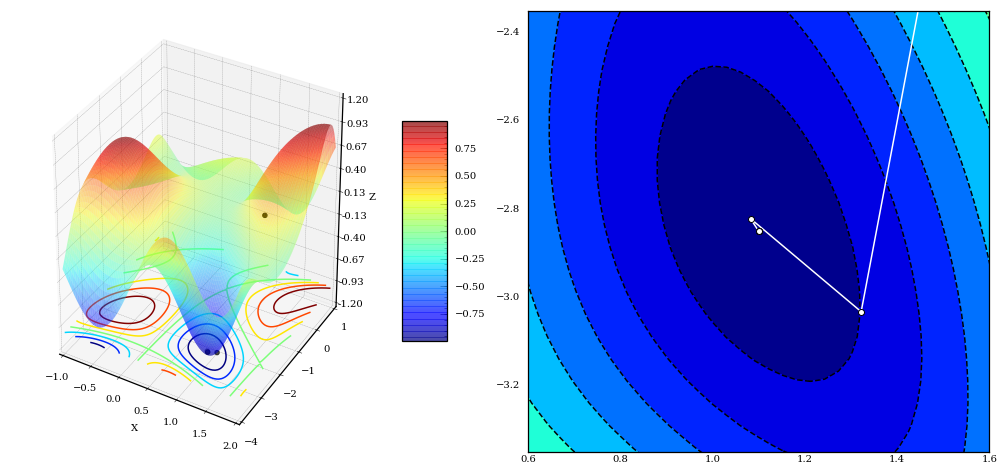

In [23]:
pf.plot_func(xminimum, xmaximum, yminimum, ymaximum, steps_x, steps_y, f)

# 5.4 Broyden-Fletcher-Goldfarb-Shanno (BFGS)

The BFGS method is one of the quasi-Newton methods and, as the name suggests, approximates the Newton-Raphson method discussed above. The major difference of a quasi-Newton method is that the Hessian is not calculated directly, but instead approximated. This approximation results in the BFGS method being more robust and often times converging more quickly than the Newton-Raphson method.
   
 The only difference to the Newton method is the update of the approximate Hessian, $H_{approx}$ and the update of the search direction. The mathematics of these updates are out of the scope of these notebooks; however, the interested reader is directed towards *Polak, E. Computational Methods in Optimization; a Unified Approach. New York: Academic, 1971. Print.* for a more detailed explanation.
 
 The code below applies the BFGS method to the example function and plots the optimization path.

In [24]:
##########
# MAIN CODE
##########
old_guess = initial_guess

approx_hessian = np.identity(2)
inverse_approx_hessian = np.identity(2)

num_steps = 0

s_i = np.array([1.0, 0.0])
y_i = np.array([0.0, 1.0])

converged = False
steps_x = []
steps_y = []
steps_x.append(old_guess[0])
steps_y.append(old_guess[1])
while not converged and num_steps <= IT_MAX:
    print("STEP {:d}".format(num_steps))
    num_steps += 1
    new_search_direction = np.dot(inverse_approx_hessian, -Gradient(old_guess))
    try:
        s_i = linesearch(f, Gradient, old_guess, new_search_direction)[
            0] * new_search_direction
    except:
        print("WARNING: HESSIAN IS NOT POSITIVE DEFINITE... RESETTING SEARCH DIRECTION TO STEEPEST DESCENT!")
        new_search_direction = -Gradient(old_guess)
        s_i = linesearch(f, Gradient, old_guess, new_search_direction)[
            0] * new_search_direction

    new_guess = old_guess + s_i
    y_i = Gradient(new_guess) - Gradient(old_guess)
    approx_hessian += ((np.outer(y_i, y_i)) / (np.dot(y_i, s_i))) - ((np.dot(approx_hessian,
                                                                             np.dot(np.outer(s_i, s_i), approx_hessian))) / (np.dot(s_i, np.dot(approx_hessian, s_i))))
    # update using Sherman-Morrison formula
    part_A = np.dot(s_i, y_i)
    part_A += np.dot(y_i, np.dot(inverse_approx_hessian, y_i))
    part_A /= np.dot(s_i, y_i)**2
    part_A *= np.outer(s_i, s_i)
    part_B = np.dot(inverse_approx_hessian, np.outer(y_i, s_i))
    part_B += np.dot(np.outer(s_i, y_i), inverse_approx_hessian)
    part_B /= np.dot(s_i, y_i)
    inverse_approx_hessian += part_A - part_B

    diff = old_guess - new_guess
    diff = np.sqrt(np.dot(diff, diff))
    print ("OLD GUESS: {}".format(old_guess))
    print ("NEW GUESS: {}".format(new_guess))
    print ("DIFFERENCE: {}".format(diff))
    old_guess = new_guess
    old_search_direction = new_search_direction
    steps_x.append(old_guess[0])
    steps_y.append(old_guess[1])
    if(diff < residual_tolerance):
        converged = True
steps_x = np.array(steps_x)
steps_y = np.array(steps_y)
steps_per_method["BFGS"] = num_steps
difference_per_method["BFGS"] = diff


STEP 0
OLD GUESS: [ 1.6 -1.5]
NEW GUESS: [ 1.32197638 -3.03485489]
DIFFERENCE: 1.5598322571776573
STEP 1
OLD GUESS: [ 1.32197638 -3.03485489]
NEW GUESS: [ 1.26399466 -3.13373111]
DIFFERENCE: 0.11462280015169479
STEP 2
OLD GUESS: [ 1.26399466 -3.13373111]
NEW GUESS: [ 1.10078247 -2.8516094 ]
DIFFERENCE: 0.3259307779886503
STEP 3
OLD GUESS: [ 1.10078247 -2.8516094 ]
NEW GUESS: [ 1.09965994 -2.85201979]
DIFFERENCE: 0.0011951915187101648
STEP 4
OLD GUESS: [ 1.09965994 -2.85201979]
NEW GUESS: [ 1.09965381 -2.85224349]
DIFFERENCE: 0.00022378266774767126
STEP 5
OLD GUESS: [ 1.09965381 -2.85224349]
NEW GUESS: [ 1.09965368 -2.85224318]
DIFFERENCE: 3.37958583922218e-07


<IPython.core.display.Javascript object>


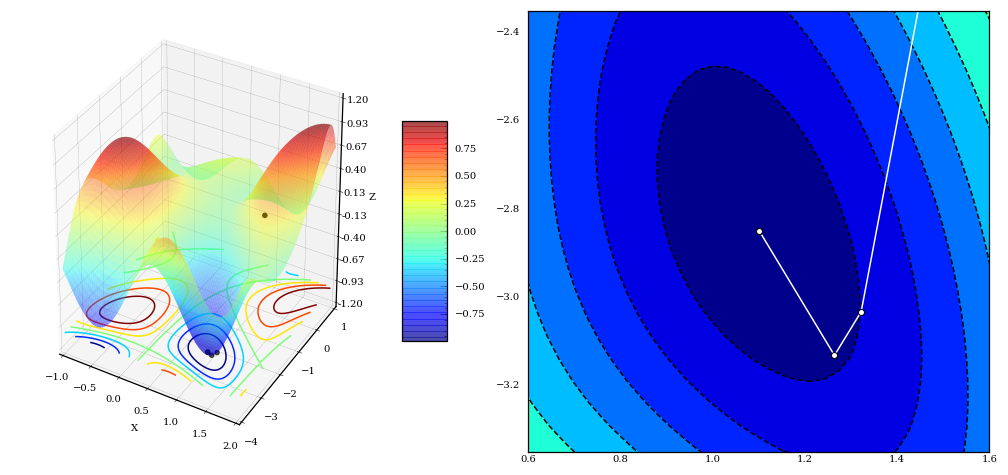

In [25]:
pf.plot_func(xminimum, xmaximum, yminimum, ymaximum, steps_x, steps_y, f)

# 5.5 Summary of Results

In [26]:
print("{:->39}".format(""))
print("{:>20} : {:>5} {:>10}".format("Method", "Steps", "Difference"))
print("{:->20}   {:->5} {:->10}".format("", "", ""))
for i in sorted(difference_per_method, key=difference_per_method.get, reverse=True):
    print("{:>20} : {:>5} {:>6.4e}".format(i, steps_per_method[i], difference_per_method[i]))
print("{:->39}".format(""))


---------------------------------------
              Method : Steps Difference
--------------------   ----- ----------
                BFGS :     6 3.3796e-07
  Conjugate Gradient :    11 9.3965e-08
      Newton-Raphson :     5 1.6015e-08
---------------------------------------


When deciding on an optimization method to use, we consider (above) the number of steps required to converge. The Newton-Raphson method converges quickly, and with great accuracy. However the Newton-Raphson method requires the calculation of a Hessian, which is expensive. The BFGS method avoids the Hessian calculation and instead iteratively builds an approximate Hessian. The BFGS method also converges quickly and is widely used in real world applications. The conjugate gradient method requires more steps to converge, but is accurate. Finally, the steepest descent method, while slow, guarantees convergence.

# 5.6 Application

## Your Task

Optimization methods are commonly used in chemistry to find the lowest energy structure of a molecule, which corresponds to the equilibrium gas phase geometry. The basic approach is to use a computational method to evaluate the energy and gradients with respect to moves of the nuclei. This energy surface can be explored using optimization methods to locate the ideal geometry. 

The code box below uses the BFGS method to optimize the Hartree-Fock energy of a ring of 6 hydrogen atoms. The two parameters that will be optimized are the radius of the ring and the ratio between pairs of hydrogen atoms. Remember the BFGS method requires first derivatives, and in this case the first derivate is calculated numerically using the central difference method.

There are two stable geometries; one with equally spaced hydrogens and another with "dimers" of hydrogens.

Run the first cell to perform the optimization, and then run the second cell to visualize the optimization.

In [27]:
# DIMERS   
# radius = 4.5 # atomic units
# deformation = 0.65 # ratio (must be less than or equal to 1)
# RING
radius = 2.0 # atomic units
deformation = 1.0 # ratio (must be less than or equal to 1)

if deformation > 1.0 or deformation < 0.0:
        deformation = np.abs(deformation) % 1.0

steps_radius, steps_deformation, steps_energy = pf.optimize_H6_ring(radius, deformation)
        

Starting optimization. Please be patient.
Step: 1
OLD GUESS: [2. 1.]
NEW GUESS: [1.80003882 1.        ]
DIFFERENCE: 0.1999611752432351

Step: 2
OLD GUESS: [1.80003882 1.        ]
NEW GUESS: [1.82101927 1.        ]
DIFFERENCE: 0.02098044357797879

Step: 3
OLD GUESS: [1.82101927 1.        ]
NEW GUESS: [1.81686686 1.        ]
DIFFERENCE: 0.0041524115463960065

Step: 4
OLD GUESS: [1.81686686 1.        ]
NEW GUESS: [1.81677424 1.        ]
DIFFERENCE: 9.26190903791646e-05



In [28]:
import ipywidgets as ipw
from ipywidgets import *
step_set = ipw.IntSlider(min=0,max =len(steps_energy)-1,value=0)
interactive_plot = ipw.interactive(pf.plotting, step=step_set,steps_radius=fixed(steps_radius), steps_energy=fixed(steps_energy),steps_deformation=fixed(steps_deformation))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=0, description='step', max=4), Output(layout=Layout(height='350px'))), _…

### Question:
Please insert the number of the correct answer into the function below.
Based on the energies of the two structures calculated above the ring with equally paired hydrogens is  
    1.) a global minimum
    2.) a local minimum
    3.) an equivilant structure to the paired hydrogens
    4.) a maximum
    5.) None of the above

In [ ]:
pf.question_one_check()